In [34]:
from ucimlrepo import fetch_ucirepo 
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import random
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import nb as nb
import nb2 as nb2
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score

In [35]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [153]:
# fetch dataset 
dataset = fetch_ucirepo(id=17) 
  
# data (as pandas dataframes) 
X = dataset.data.features 
y = dataset.data.targets 

num_classes = len(y.Diagnosis.unique())
num_features = len(X.columns)

print(X.sample(1))
# print(np.mean(X.radius1))
# print(y.sample(3))
# X.shape = (569, 30) -> (sample_num, features_num) features has different mean variance
# y.shape = (569, 1)  -> (sample_num, diagnosis) M or B

# metadata (information about dataset)
#print(dataset.metadata) 
  
# variable information 
# print(dataset.variables.name[31]) 
# print(len(dataset.variables))

# y.Diagnosis.hist()

    radius1  texture1  perimeter1  area1  smoothness1  compactness1  \
73     13.8     15.79       90.43  584.1       0.1007         0.128   

    concavity1  concave_points1  symmetry1  fractal_dimension1  radius2  \
73     0.07789          0.05069     0.1662             0.06566   0.2787   

    texture2  perimeter2  area2  smoothness2  compactness2  concavity2  \
73    0.6205       1.957  23.35     0.004717       0.02065     0.01759   

    concave_points2  symmetry2  fractal_dimension2  radius3  texture3  \
73         0.009206     0.0122             0.00313    16.57     20.86   

    perimeter3  area3  smoothness3  compactness3  concavity3  concave_points3  \
73       110.3  812.4       0.1411        0.3542      0.2779           0.1383   

    symmetry3  fractal_dimension3  
73     0.2589               0.103  


In [37]:
set = [X, y]
X = pd.concat(set, axis=1)

<Axes: >

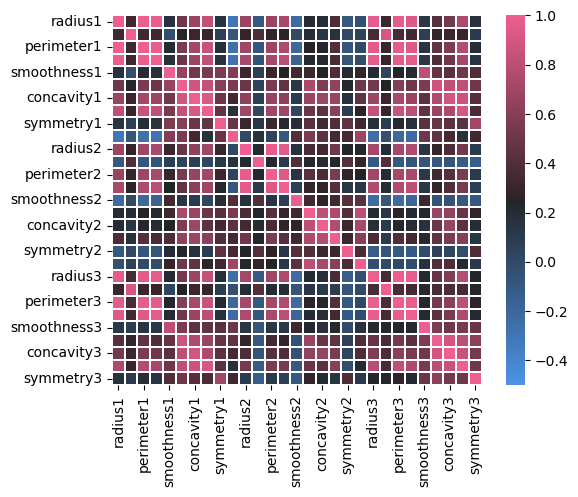

In [154]:
# Correlation matrix
corr = X.iloc[:,:-1].corr(method="pearson")
cmap = sns.diverging_palette(250,354,80,60,center='dark',as_cmap=True)
sns.heatmap(corr, vmax=1, vmin=-.5, cmap=cmap, square=True, linewidths=.2) 

In [ ]:
# Table of input values
X.head(10)

radius1
texture1
area1


<Axes: xlabel='area1', ylabel='Count'>

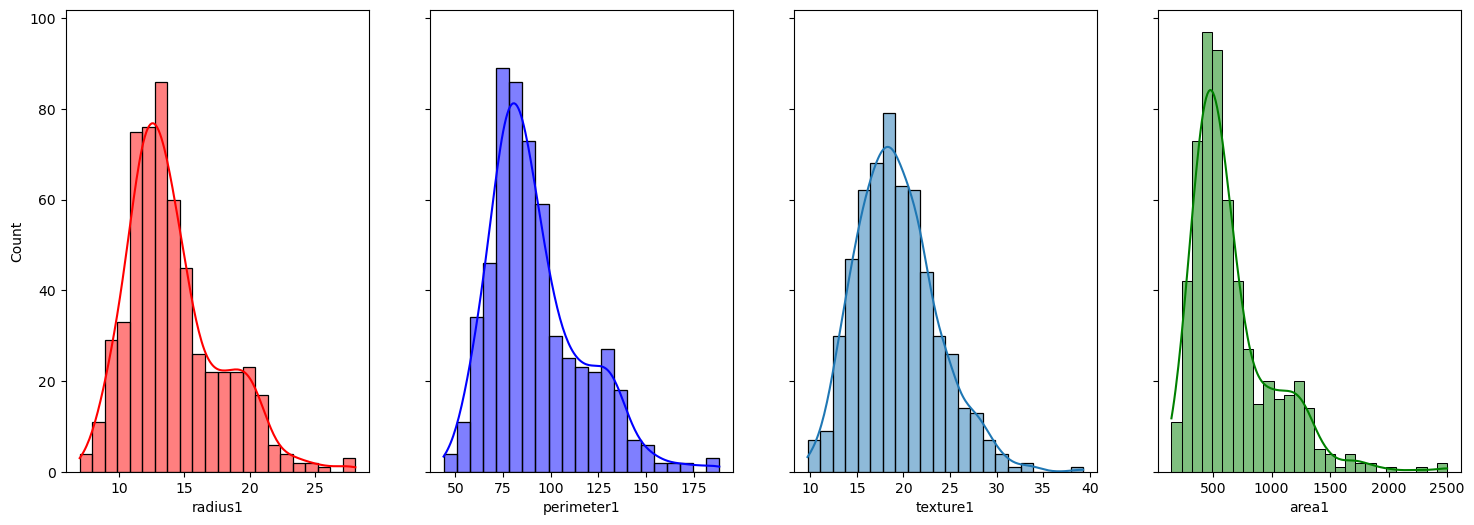

In [155]:
print(dataset.variables.name[2])
print(dataset.variables.name[3])
print(dataset.variables.name[5])

fig, axes = plt.subplots(1, 4, figsize=(18, 6), sharey=True)
sns.histplot(X, ax=axes[0], x="radius1", kde=True, color='r')
sns.histplot(X, ax=axes[1], x="perimeter1", kde=True, color='b')
sns.histplot(X, ax=axes[2], x="texture1", kde=True)
sns.histplot(X, ax=axes[3], x="area1", kde=True, color='g')

In [65]:
# Split dataset into training and testing subsets
def train_test_split(X, test_ratio=0.1, random_seed=None):

    if random_seed:
        random.seed(random_seed)
    
    # Shuffle the indices
    indices = list(range(len(X)))
    random.shuffle(indices)
    
    # Calculate the number of samples for the testing set
    test_size = int(len(X) * test_ratio)
    train_size = len(X) - test_size
    
    # Create the training and testing subsets
    X_train = X.sample(train_size)
    X_test = X.sample(test_size)
    
    return X_train, X_test


X_train, X_test = train_test_split(X, 0.1, 42)

y_train = X_train.Diagnosis
y_train = y_train.to_numpy().reshape(-1, 1)
y_train = np.asarray(y_train, dtype=str)

y_test = X_test.Diagnosis
y_test = y_test.to_numpy().reshape(-1, 1)
y_test= np.asarray(y_test, dtype=str)


In [66]:
# Split data to classes
class_M = X_train[X_train['Diagnosis'] == 'M']
class_B = X_train[X_train['Diagnosis'] == 'B']

In [67]:
# Calculate the means and variances of the features
prior_m = len(class_M)/len(X_train)
prior_b = len(class_B)/len(X_train)

means = []
variances = []
for i in range (2,len(dataset.variables)):
    means.append(np.mean(X_train[dataset.variables.name[i]]))
    variances.append(np.var(X_train[dataset.variables.name[i]]))
    
means_m = []
variances_m = []
for i in range (2,len(dataset.variables)):
    means_m.append(np.mean(class_M[dataset.variables.name[i]]))
    variances_m.append(np.var(class_M[dataset.variables.name[i]]))

means_b = []
variances_b = []
for i in range (2,len(dataset.variables)):
    means_b.append(np.mean(class_B[dataset.variables.name[i]]))
    variances_b.append(np.var(class_B[dataset.variables.name[i]]))


In [68]:
# Predict
def predict(samples):
    posterior_m = prior_m
    posterior_b = prior_b

    predictions = []

    for sample in samples: # for all samples
        for i in range (30): # for all features

            likelihood_m = (1/(np.sqrt(2*np.pi*variances_m[i])))*np.exp(-((sample[i]-means_m[i])**2)/(2*variances_m[i]))
            likelihood_b = (1/(np.sqrt(2*np.pi*variances_b[i])))*np.exp(-((sample[i]-means_b[i])**2)/(2*variances_b[i]))
            posterior_m = posterior_m * likelihood_m
            posterior_b = posterior_b * likelihood_b

        if(posterior_m > posterior_b):
            predictions.append(1)
        else:
            predictions.append(0)
        
        posterior_b = prior_b
        posterior_m = prior_m
            
    return predictions
    


In [150]:
def density_function(x, mean, sigma):
    # Calculate probability from Gaussian density function
    eps = np.full_like(sigma, 1e-6)
    const = -num_classes / 2 * np.log(2 * np.pi) - 0.5 * np.sum(np.log(sigma + eps))
    probs = 0.5 * np.sum(np.power(x - mean, 2) / (sigma + eps), 1)
    
    avg_array = np.mean((const - probs), axis=0)
    return avg_array
    
def predict2(X):
    # X is 56,30
    num_classes = 2
    num_features = 30
    probs = np.zeros((X.shape[0], num_classes)) # 30,2

    probs_m = density_function(X, means_m, variances_m) # 56,30
    probs_b = density_function(X, means_b, variances_b)

    probs[:, 0] = probs_m + np.log(prior_m)
    probs[:, 1] = probs_b + np.log(prior_b)

    return np.argmax(probs, 1)
    

In [157]:
# Testing Performance 

x_test = []
for i in range (2,32):
    x_test.append(X_test[dataset.variables.name[i]].to_numpy())
x_test = np.array(x_test).T

Y_test = np.zeros((len(y_test)))
for i in range(len(y_test)):
    if y_test[i] == 'M':
        Y_test[i] = 1

Y_pred = predict(x_test)

#print(Y_test.shape, Y_pred.shape)

print(confusion_matrix(Y_test, Y_pred))
print(f1_score(Y_test, Y_pred))

[[34  3]
 [ 2 17]]
0.8717948717948718


In [14]:
# Convert y_train to one-hot encoding
encoded_y = np.zeros((len(y_train), 2))
for i in range(len(y_train)):
    if y_train[i] == 'M':
        encoded_y[i, 0] = 1
    else:
        encoded_y[i, 1] = 1


In [15]:
X_train = X_train.drop(columns=['Diagnosis'])

In [16]:
# Define model
input_dim = X_train.shape[1]
num_classes = 2

model = nb.NaiveBayes(input_dim, num_classes)


In [17]:
# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [18]:
data_x = []
for i in range (2,32):
    data_x.append(X_train[dataset.variables.name[i]].to_numpy())

data_x = np.array(data_x)

In [19]:
normalized_data = []

for i in range (0,30):
    #normalized_data.append(1/variances[i]*np.exp(-((data_x[i]-means[i])**2)/(2*variances[i])))
    normalized_data.append((data_x[i] - np.mean(data_x[i]))/np.std(data_x[i]))

In [20]:
x_tensor = torch.tensor(data_x, dtype=torch.float64).t()
print(x_tensor.shape)

y_tensor = torch.tensor(encoded_y, dtype=torch.float64)
print(y_tensor.shape)

torch.Size([534, 30])
torch.Size([534, 2])


In [21]:
# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(x_tensor)
    loss = criterion(outputs, y_tensor)
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [10/100], Loss: 896622.9188
Epoch [20/100], Loss: 189410.8084
Epoch [30/100], Loss: 21379.5405
Epoch [40/100], Loss: 8374.3436
Epoch [50/100], Loss: 7262.6933
Epoch [60/100], Loss: 7431.8361
Epoch [70/100], Loss: 6738.3097
Epoch [80/100], Loss: 4518.5615
Epoch [90/100], Loss: 3491.3466
Epoch [100/100], Loss: 3009.7253


In [ ]:

# Test the model
with torch.no_grad():
    predicted = model.predict(X_test)
    accuracy = (predicted.numpy() == y_test).mean()
    print(f'Test Accuracy: {accuracy:.4f}')